# Recommendations with IBM
## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [103]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [104]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    """
    Maps each unique email in the 'email' column of df to a unique integer user ID.

    Returns:
        list: A list of integer user IDs corresponding to each row in df.
    """

    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
df['user_id'] = email_encoded
del df['email']

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


Descriptive statistics for user-article interactions:
count    5149.000000
mean        8.932414
std        16.801011
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64


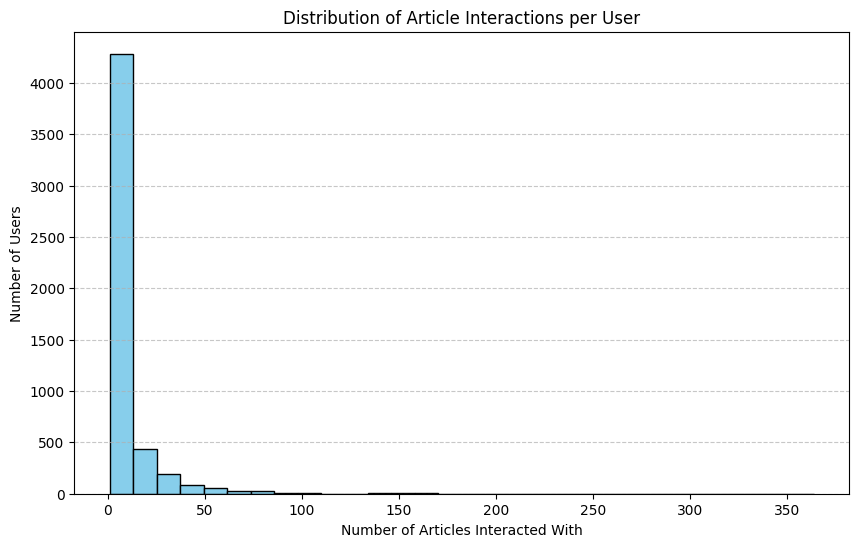

In [105]:
# Calculate the number of articles each user has interacted with
user_article_counts = df.groupby('user_id')['article_id'].count()

# Display descriptive statistics
print("Descriptive statistics for user-article interactions:")
print(user_article_counts.describe())

# Visualize the distribution
plt.figure(figsize=(10,6))
plt.hist(user_article_counts, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Article Interactions per User')
plt.xlabel('Number of Articles Interacted With')
plt.ylabel('Number of Users')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [106]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3 # 50% of individuals interact with 3 articles or fewer.
max_views_by_user = 364 # The maximum number of user-article interactions by any 1 user is 364.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [107]:
# Check for duplicate articles based on 'article_id'
num_duplicates = df_content.duplicated(subset='article_id').sum()
print(f"Number of duplicate articles based on 'article_id': {num_duplicates}")

# Display duplicate rows if any
if num_duplicates > 0:
    display(df_content[df_content.duplicated(subset='article_id', keep=False)])

Number of duplicate articles based on 'article_id': 5


,doc_body,doc_description,doc_full_name,doc_status,article_id
50,Follow Sign in / Sign up Home About Insight Da...,Community Detection at Scale,Graph-based machine learning,Live,50
221,* United States\r\n\r\nIBM® * Site map\r\n\r\n...,When used to make sense of huge amounts of con...,How smart catalogs can turn the big data flood...,Live,221
232,Homepage Follow Sign in Get started Homepage *...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
399,Homepage Follow Sign in Get started * Home\r\n...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
578,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [108]:
# Remove duplicate articles, keeping only the first occurrence
df_content = df_content.drop_duplicates(subset='article_id', keep='first').reset_index(drop=True)

# Confirm removal
print(f"Number of articles after removing duplicates: {df_content.shape[0]}")

Number of articles after removing duplicates: 1051


`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [109]:

# a. Number of unique articles that have at least one interaction
unique_articles = df['article_id'].nunique()

# b. Number of unique articles in the dataset (IBM platform)
total_articles = df_content['article_id'].nunique()

# c. Number of unique users (excluding null values)
unique_users = df['user_id'].nunique()

# d. Number of user-article interactions in the dataset
user_article_interactions = df.shape[0]

print(f"Unique articles with interactions: {unique_articles}")
print(f"Total unique articles on platform: {total_articles}")
print(f"Unique users: {unique_users}")
print(f"Total user-article interactions: {user_article_interactions}")

Unique articles with interactions: 714
Total unique articles on platform: 1051
Unique users: 5149
Total user-article interactions: 45993


In [110]:
unique_articles = int(unique_articles) # The number of unique articles that have at least one interaction
total_articles = int(total_articles) # The number of unique articles on the IBM platform
unique_users = int(unique_users) # The number of unique users
user_article_interactions = int(user_article_interactions) # The number of user-article interactions


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [111]:
# Find the most viewed article_id and the number of views
article_view_counts = df['article_id'].value_counts()
most_viewed_article_id = str(article_view_counts.idxmax())  # as a string with one value following the decimal
max_views = article_view_counts.max()

print(f"Most viewed article_id: {most_viewed_article_id}")
print(f"Number of views: {max_views}")

Most viewed article_id: 1429.0
Number of views: 937


In [112]:
most_viewed_article_id = str(most_viewed_article_id) # The most viewed article in the dataset as a string with one value following the decimal 
max_views = int(max_views) # The most viewed article in the dataset was viewed how many times?

In [113]:
# The unique_user is correct, but why is it complaining? Debugging:
print("unique_users:", unique_users, type(unique_users))
print("df['user_id'].nunique():", df['user_id'].nunique())
print("df.shape:", df.shape)

## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

unique_users: 5149 <class 'int'>
df['user_id'].nunique(): 5149
df.shape: (45993, 3)
Oops! It looks like the value associated with: `The number of unique users in the dataset is ______` wasn't right. Try again.  It might just be the datatype.  All of the values should be ints except the article_id should be a string.  Let each row be considered a separate user-article interaction.  If a user interacts with an article 3 times, these are considered 3 separate interactions.

  Notice you may also find the number of unique users as 5149 if you count the null user.  However, this is hard to catch without mapping first!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [114]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    '''
    # Get the top n article_ids by interaction count
    top_ids = df['article_id'].value_counts().index[:n]
    # Get unique titles for those article_ids, preserving order
    top_articles = [df[df['article_id'] == aid]['title'].iloc[0] for aid in top_ids]
    return top_articles

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids as strings
    '''
    # Get the top n article_ids by interaction count, convert to string with one decimal
    top_articles = [str(aid) for aid in df['article_id'].value_counts().index[:n]]
    return top_articles

In [115]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [116]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [117]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns

    OUTPUT:
    user_item - user item matrix 

    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    user_item = df.groupby(['user_id', 'article_id'])['title'].max().unstack().notnull().astype(int)
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [118]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [119]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first

    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list of the users in order from most to least similar
    '''
    # Compute similarity of each user to the provided user
    target_vector = user_item.loc[user_id].values
    similarities = user_item.dot(target_vector)
    
    # Sort by similarity (descending), then by user_id (ascending) for tie-breaking
    similarities = similarities.sort_values(ascending=False)
    
    # Remove the own user's id
    most_similar_users = similarities.index.tolist()
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [120]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [121]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Ensure all ids are strings with one decimal
    article_ids = [str(float(aid)) for aid in article_ids]
    # Get unique titles for the given article ids
    article_names = df[df['article_id'].astype(str).isin(article_ids)]['title'].drop_duplicates().tolist()
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Get article ids where user has interacted (value == 1)
    article_ids = user_item.loc[user_id][user_item.loc[user_id] == 1].index.astype(str).tolist()
    # Get article names using get_article_names
    article_names = get_article_names(article_ids)
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Get articles seen by the user
    user_articles, _ = get_user_articles(user_id)
    # Find similar users
    similar_users = find_similar_users(user_id)
    recs = []
    # Loop through similar users and collect unseen articles
    for sim_user in similar_users:
        sim_user_articles, _ = get_user_articles(sim_user)
        # Recommend articles not already seen
        new_recs = [aid for aid in sim_user_articles if aid not in recs and aid not in user_articles]
        recs.extend(new_recs)
        if len(recs) >= m:
            break
    return recs[:m] # return your recommendations for this user_id

In [122]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'timeseries data analysis of iot events by using jupyter notebook',
 'graph-based machine learning',
 'using brunel in ipython/jupyter notebooks',
 'experience iot with coursera',
 'the 3 kinds of context: machine learning and the art of the frame',
 'deep forest: towards an alternative to deep neural networks',
 'this week in data science (april 18, 2017)',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty']

In [123]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [124]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user

    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
    '''
    # Compute similarity of each user to the provided user
    target_vector = user_item.loc[user_id].values
    similarities = user_item.dot(target_vector)
    # Remove the own user's id
    similarities = similarities.drop(user_id)
    # Get number of interactions for each user
    num_interactions = user_item.sum(axis=1)
    # Build dataframe
    neighbors_df = pd.DataFrame({
        'neighbor_id': similarities.index,
        'similarity': similarities.values,
        'num_interactions': num_interactions.loc[similarities.index].values
    })
    # Sort by similarity (desc), then num_interactions (desc)
    neighbors_df = neighbors_df.sort_values(['similarity', 'num_interactions'], ascending=[False, False])
    neighbors_df.reset_index(drop=True, inplace=True)
    return neighbors_df

def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user

    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title

    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found

    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
    '''
    # Articles already seen by the user
    user_articles, _ = get_user_articles(user_id)
    # Get sorted neighbors
    neighbors_df = get_top_sorted_users(user_id)
    recs = []
    # Get article popularity (for tie-breaking)
    article_popularity = df['article_id'].value_counts()
    # Loop through neighbors
    for neighbor_id in neighbors_df['neighbor_id']:
        neighbor_articles, _ = get_user_articles(neighbor_id)
        # Recommend articles not already seen or already recommended
        new_recs = [aid for aid in neighbor_articles if aid not in recs and aid not in user_articles]
        recs.extend(new_recs)
        if len(recs) >= m:
            break
    # Sort recommendations by overall popularity
    recs_sorted = sorted(recs, key=lambda aid: article_popularity.get(float(aid), 0), reverse=True)
    recs_sorted = recs_sorted[:m]
    rec_names = get_article_names(recs_sorted)
    return recs_sorted, rec_names

In [125]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1429.0', '1330.0', '1314.0', '1293.0', '1162.0', '1271.0', '43.0', '1351.0', '1368.0', '1305.0']

The top 10 recommendations for user 20 are the following article names:
['healthcare python streaming application demo', 'use deep learning for image classification', 'analyze energy consumption in buildings', 'putting a human face on machine learning', 'gosales transactions for naive bayes model', 'insights from new york car accident reports', 'model bike sharing data with spss', 'finding optimal locations of new store using decision optimization', 'deep learning with tensorflow course by big data university', 'customer demographics and sales']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [126]:
### Tests with a dictionary of results

user1_most_sim = get_top_sorted_users(1).iloc[0]['neighbor_id'] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).iloc[10]['neighbor_id'] # Find the 10th most similar user to user 131

print("Most similar user to user 1:", user1_most_sim)
print("10th most similar user to user 131:", user131_10th_sim)
# The test take the 11th (with index=10) instead of 10th (index=0)!
print(get_top_sorted_users(131).head(15))

Most similar user to user 1: 3933
10th most similar user to user 131: 242
    neighbor_id  similarity  num_interactions
0          3870          74                75
1          3782          39               135
2            23          38               135
3           203          33                96
4          4459          33                96
5            49          29               101
6          3697          29               100
7            98          29                97
8          3764          29                97
9          3910          25                60
10          242          25                59
11           40          24                52
12         4932          24                52
13         3740          23                71
14           58          23                70


In [127]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': int(user1_most_sim), 
    'The user that is the 10th most similar to user 131': int(user131_10th_sim)
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

**Provide your response here.**

We cannot use collaborative filtering functions like find_similar_users or user_user_recs for a new user because there is no interaction history to compare with other users. The only functions we can use are `get_top_articles` or `get_top_article_ids`, which recommend the most popular articles.


A content-based approach to making recommendations for new users would be better. For example, we could ask the new user about their interests or preferred topics during onboarding and then recommend articles that match those interests using article metadata (such as keywords, tags, or descriptions). This would provide more personalized recommendations than simply showing the most popular articles.

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [128]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)

print(new_user_recs)



['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [129]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

In [130]:
def make_content_recs(term, n=10, df_content=df_content, df=df):
    '''
    Recommend the top n most popular articles whose content matches the given term.
    '''
    # Search for the term in doc_description or doc_full_name (case-insensitive)
    mask = (
        df_content['doc_description'].str.contains(term, case=False, na=False) |
        df_content['doc_full_name'].str.contains(term, case=False, na=False)
    )
    filtered_articles = df_content[mask].copy()

    # Get article popularity from interactions
    article_popularity = df['article_id'].value_counts()

    # Sort filtered articles by popularity
    filtered_articles['popularity'] = filtered_articles['article_id'].map(article_popularity).fillna(0)
    filtered_articles = filtered_articles.sort_values('popularity', ascending=False)

    # Get top n article ids and titles (use doc_full_name for title)
    rec_article_ids = filtered_articles['article_id'].astype(str).head(n).tolist()
    rec_titles = filtered_articles['doc_full_name'].head(n).tolist()

    return rec_article_ids, rec_titles

In [131]:
ids, titles = make_content_recs('python', n=5)
print(ids)
print(titles)

['124', '1017', '681', '542', '812']
['Python Machine Learning: Scikit-Learn Tutorial', 'The pandas Data Analysis Library', 'Real-Time Sentiment Analysis of Twitter Hashtags with Spark (+ PixieDust)', 'Getting started with Python', 'Machine Learning Exercises In Python, Part 1']


`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

My content-based recommender works by searching for a user-provided keyword (such as "python") within the `doc_description` and `doc_full_name` fields of the article's metadata. It filters the articles that match the keyword and ranks these filtered articles by their popularity, which is determined by the number of user interactions each article has received. The top N articles are then recommended, and both their IDs and titles are returned.

**Possible improvements:**
- Expand the search to include the `doc_body` field for more comprehensive matching.
- To improve keyword matching and capture related terms, use more advanced natural language processing techniques like stemming, lemmatisation, or embeddings.
- Personalise recommendations by excluding articles the user has already seen or by combining content-based and collaborative filtering.
- Allow for multi-keyword or topic-based searches to provide more tailored results.

**Novelty:**
The recommender is interpretable and straightforward, combining keyword-based filtering with popularity ranking. While not highly novel, it is effective for cold-start scenarios and can be easily extended with more sophisticated text analysis or hybrid approaches.

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [132]:
# Recommendations for a brand new user (no interaction history)
# Let's assume the new user is interested in "machine learning"
new_user_ids, new_user_titles = make_content_recs('machine learning', n=5)
print("Recommendations for a brand new user (interested in 'machine learning'):")
print(new_user_ids)
print(new_user_titles)

# Recommendations for a user who has only interacted with article id '1427.0'
# Let's recommend articles related to the topic of article 1427.0
article_1427_title = df[df['article_id'] == 1427.0]['title'].iloc[0]
print("\nArticle 1427.0 title:", article_1427_title)

# Use a keyword from the title for content-based recommendations
keyword = 'xgboost'  # or another relevant keyword from the title
single_article_user_ids, single_article_user_titles = make_content_recs(keyword, n=5)
print(f"\nRecommendations for a user who has only interacted with article id '1427.0' (keyword: '{keyword}'):")
print(single_article_user_ids)
print(single_article_user_titles)

Recommendations for a brand new user (interested in 'machine learning'):
['124', '732', '260', '237', '250']
['Python Machine Learning: Scikit-Learn Tutorial', 'Rapidly build Machine Learning flows with DSX', 'The Machine Learning Database', 'Deep Learning with Data Science Experience', 'Building Your First Machine Learning System ']

Article 1427.0 title: use xgboost, scikit-learn & ibm watson machine learning apis

Recommendations for a user who has only interacted with article id '1427.0' (keyword: 'xgboost'):
['130']
["Feature importance and why it's important"]


### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [133]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [134]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [135]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=False)

In this situation, we can use Singular Value Decomposition (SVD) directly on the user-item matrix because the matrix contains only 1s and 0s (indicating whether a user has interacted with an article). 

This is different from the lesson, where we had explicit ratings and needed to fill in missing values before applying SVD. Here, the absence of an interaction is simply represented by a 0, so we do not need to impute missing values.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

/opt/anaconda3/envs/data-science/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


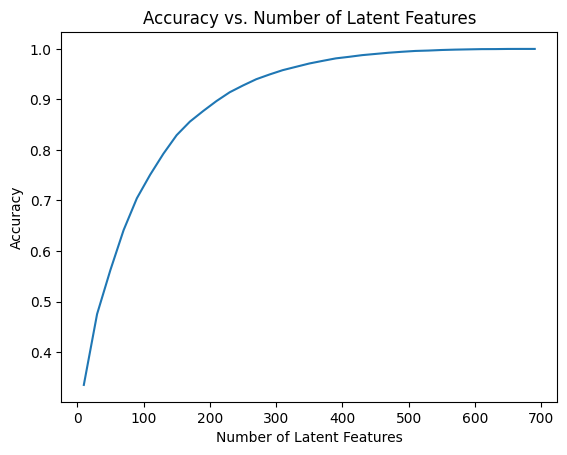

In [136]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [137]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe

    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
    user_item_test - a user-item matrix of the testing dataframe 
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    '''
    user_item_train = df_train.groupby(['user_id', 'article_id'])['title'].max().unstack().notnull().astype(int)
    user_item_test = df_test.groupby(['user_id', 'article_id'])['title'].max().unstack().notnull().astype(int)
    test_idx = list(user_item_test.index)
    test_arts = list(user_item_test.columns)
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [138]:
# Calculate answers for the cold start problem
# Users in test set that are also in train set
test_users_in_train = set(user_item_test.index).intersection(set(user_item_train.index))
# Users in test set not in train set (cold start)
test_users_not_in_train = set(user_item_test.index) - set(user_item_train.index)
# Articles in test set that are also in train set
test_arts_in_train = set(user_item_test.columns).intersection(set(user_item_train.columns))
# Articles in test set not in train set (cold start)
test_arts_not_in_train = set(user_item_test.columns) - set(user_item_train.columns)

a = len(test_users_in_train)   # Users we can make predictions for
b = len(test_users_not_in_train)  # Users we cannot make predictions for (cold start)
c = len(test_arts_in_train)    # Articles we can make predictions for
d = len(test_arts_not_in_train)   # Articles we cannot make predictions for (cold start)

print(f"Users in test set that are also in train set: {a}")
print(f"Users in test set not in train set (cold start): {b}")
print(f"Articles in test set that are also in train set: {c}")
print(f"Articles in test set not in train set (cold start): {d}")


Users in test set that are also in train set: 20
Users in test set not in train set (cold start): 662
Articles in test set that are also in train set: 574
Articles in test set not in train set (cold start): 0


In [139]:
# Replace the values in the dictionary below
a = a 
b = b 
c = c 
d = d


sol_4_dict = {
    'How many users can we make predictions for in the test set?': a, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': b, 
    'How many articles can we make predictions for in the test set?': c,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [140]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=False)

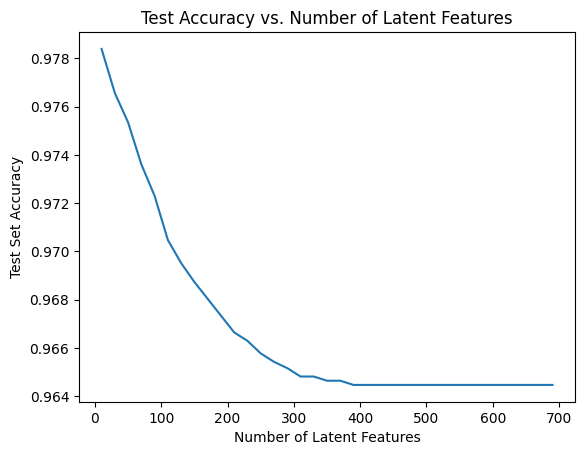

In [141]:
# Find users and articles in both train and test sets
common_test_users = list(set(user_item_test.index) & set(user_item_train.index))
common_test_articles = list(set(user_item_test.columns) & set(user_item_train.columns))

# Indices for slicing
user_inds = [user_item_train.index.get_loc(u) for u in common_test_users]
article_inds = [user_item_train.columns.get_loc(a) for a in common_test_articles]

# Evaluate accuracy for different numbers of latent features
num_latent_feats = np.arange(10, 700+10, 20)
test_accuracies = []

for k in num_latent_feats:
    # Reconstruct with k latent features
    u_k = u_train[:, :k]
    s_k = np.diag(s_train[:k])
    vt_k = vt_train[:k, :]
    user_item_est = np.dot(np.dot(u_k, s_k), vt_k)
    
    # Only evaluate on users and articles in both train and test
    preds = np.around(user_item_est[np.ix_(user_inds, article_inds)])
    actual = user_item_test.loc[common_test_users, common_test_articles].values
    
    # Calculate accuracy
    accuracy = 1 - np.sum(np.abs(actual - preds)) / actual.size
    test_accuracies.append(accuracy)

plt.plot(num_latent_feats, test_accuracies)
plt.xlabel('Number of Latent Features')
plt.ylabel('Test Set Accuracy')
plt.title('Test Accuracy vs. Number of Latent Features')
plt.show()

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Comment on SVD Test Accuracy Results:**

The plot above shows that as the number of latent features increases, the test set accuracy actually decreases. This suggests that the SVD model is overfitting to the training data: it learns patterns that do not generalize well to new users and articles in the test set. This is a common issue when the data is sparse and there are many users or articles in the test set that were not seen during training (the cold start problem).

**How to Evaluate Recommendation System Improvements:**

To determine if the recommendations from any of the above systems are an improvement over how users currently find articles, I would:

- **A/B Testing:** Deploy the new recommendation system to a subset of users and compare their engagement (clicks, time spent, conversions) to users using the current system.
- **User Feedback:** Collect direct feedback from users about the relevance and usefulness of the recommendations.
- **Offline Metrics:** Use offline metrics like precision, recall, and coverage on a holdout set, but always validate with real user behavior.
- **Cold Start Solutions:** Consider hybrid or content-based methods to address cold start users and articles, since collaborative filtering alone struggles in these cases.

Ultimately, real user engagement and satisfaction are the best indicators of improvement, not just offline accuracy.